# Lab1 — Линейная регрессия и соревнование на Kaggle

**Цель работы:**  
Обучить модель линейной регрессии для предсказания `RiskScore` по данным из `train.csv`,
вывести предсказания для `test.csv` и отправить на Kaggle.  
Основная метрика — MSE, требуется добиться `MSE < 25` на публичном leaderboard.

В работе реализовано:
- Разведочный анализ данных (EDA) с графиками.
- Собственные нормализации: z-score и min-max.
- Собственный класс линейной регрессии:
  - аналитическое решение;
  - градиентный спуск;
  - стохастический градиентный спуск;
  - L2-регуляризация.
- Реализация k-fold и leave-one-out кросс-валидации.
- Реализация метрик MSE, MAE, R², MAPE и сравнение со `sklearn`.
- Финальная модель линейной регрессии (с полиномиальными признаками и L2),
  дающая `MSE < 25` на Kaggle.

In [84]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.linear_model import LinearRegression, Ridge

In [85]:
TRAIN_PATH = "train.csv"
TEST_PATH  = "test.csv"

TARGET_COL = "RiskScore"
ID_COL     = "ID"
train_raw = pd.read_csv(TRAIN_PATH)
test_raw  = pd.read_csv(TEST_PATH)

print("Формы данных:")
print("train_raw:", train_raw.shape)
print("test_raw :", test_raw.shape)

display(train_raw.head())

print("\nТипы данных:")
print(train_raw.dtypes)

print("\nОписание числовых признаков:")
display(train_raw.describe())

Формы данных:
train_raw: (11017, 35)
test_raw : (5000, 35)


,ApplicationDate,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,CreditCardUtilizationRate,NumberOfOpenCreditLines,NumberOfCreditInquiries,DebtToIncomeRatio,BankruptcyHistory,LoanPurpose,PreviousLoanDefaults,PaymentHistory,LengthOfCreditHistory,SavingsAccountBalance,CheckingAccountBalance,TotalAssets,TotalLiabilities,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,EmploymentStatus,EducationLevel,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,RiskScore
0,2010-06-26,27.0,66829.0,549.0,17290.0,60.0,Divorced,1.0,Rent,1095.0,0.151985,2.0,1.0,0.168542,0.0,Education,0.0,23.0,5.0,2539.0,247.0,50072.0,15005.0,5569.083333,0.908289,4.0,Employed,Associate,4.0,35067.0,0.257790,0.251465,508.970230,0.288013,66.176500
1,1996-09-23,55.0,172147.0,850.0,16110.0,36.0,Widowed,1.0,Mortgage,211.0,0.175693,3.0,0.0,0.141553,0.0,Home,0.0,27.0,11.0,844.0,694.0,91878.0,64877.0,14345.583333,0.797339,2.0,Employed,High School,33.0,27001.0,0.086110,0.093173,514.675859,0.050585,28.495737
2,2015-01-19,51.0,300000.0,850.0,38436.0,36.0,Married,0.0,Mortgage,546.0,0.444605,3.0,0.0,0.030987,1.0,Education,0.0,21.0,12.0,12756.0,651.0,292300.0,13918.0,25000.000000,0.915945,3.0,Employed,Bachelor,28.0,278382.0,0.108436,0.115443,1268.276385,0.072571,34.488104
3,1981-05-12,25.0,34683.0,847.0,19186.0,48.0,Married,0.0,Other,153.0,0.188452,7.0,0.0,0.379843,0.0,Debt Consolidation,0.0,27.0,21.0,1524.0,529.0,13070.0,3846.0,2890.250000,0.876416,3.0,Employed,High School,0.0,9224.0,0.100686,0.112822,498.505187,0.225415,36.910753
4,1995-05-07,55.0,300000.0,850.0,30437.0,48.0,Single,2.0,Rent,562.0,0.273431,3.0,1.0,0.068659,0.0,Debt Consolidation,0.0,35.0,9.0,1973.0,128.0,33357.0,351603.0,25000.000000,0.888689,5.0,Employed,Bachelor,31.0,4502.0,0.110437,0.089037,756.035156,0.052721,31.347091



Типы данных:
ApplicationDate                object
Age                           float64
AnnualIncome                  float64
CreditScore                   float64
LoanAmount                    float64
LoanDuration                  float64
MaritalStatus                  object
NumberOfDependents            float64
HomeOwnershipStatus            object
MonthlyDebtPayments           float64
CreditCardUtilizationRate     float64
NumberOfOpenCreditLines       float64
NumberOfCreditInquiries       float64
DebtToIncomeRatio             float64
BankruptcyHistory             float64
LoanPurpose                    object
PreviousLoanDefaults          float64
PaymentHistory                float64
LengthOfCreditHistory         float64
SavingsAccountBalance         float64
CheckingAccountBalance        float64
TotalAssets                   float64
TotalLiabilities              float64
MonthlyIncome                 float64
UtilityBillsPaymentHistory    float64
JobTenure                     float6

,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,NumberOfDependents,MonthlyDebtPayments,CreditCardUtilizationRate,NumberOfOpenCreditLines,NumberOfCreditInquiries,DebtToIncomeRatio,BankruptcyHistory,PreviousLoanDefaults,PaymentHistory,LengthOfCreditHistory,SavingsAccountBalance,CheckingAccountBalance,TotalAssets,TotalLiabilities,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,RiskScore
count,10487.000000,10487.000000,9986.000000,9986.000000,10487.000000,10487.000000,9986.000000,10487.000000,10487.000000,10487.000000,10487.000000,9986.000000,10487.000000,10487.000000,10487.000000,10487.000000,9986.000000,9.986000e+03,1.048700e+04,10487.000000,10487.000000,10487.000000,10487.000000,9.986000e+03,9986.000000,10487.000000,10487.000000,10487.000000,1.048700e+04
mean,39.850386,131587.872127,678.082716,29874.218306,53.439878,1.568323,546.458642,0.284397,3.033565,0.979498,0.250610,0.052574,0.096405,24.008868,15.625250,5484.590159,1988.494893,1.830476e+05,6.881696e+04,10838.934141,0.784428,4.949271,17.628302,1.542381e+05,0.200392,0.200112,1075.622426,0.517577,-2.569878e+04
std,11.614132,115791.941909,175.192486,27705.509722,24.493562,1.418684,501.981888,0.159240,1.740186,0.990927,0.144543,0.223192,0.295160,4.844917,8.680774,8490.327012,3047.919512,4.673964e+05,2.032359e+05,9385.924858,0.123039,2.201100,11.337248,4.622229e+05,0.094388,0.096458,1344.053181,0.894637,1.431675e+06
min,18.000000,15000.000000,300.000000,1063.000000,12.000000,0.000000,13.000000,0.003674,0.000000,0.000000,0.003227,0.000000,0.000000,8.000000,1.000000,31.000000,16.000000,8.920000e+02,7.800000e+01,1250.000000,0.259301,0.000000,0.000000,1.004000e+03,0.052494,0.046445,30.008506,0.006064,-9.999999e+06
25%,32.000000,20959.500000,550.000000,12658.000000,36.000000,0.000000,233.250000,0.158929,2.000000,0.000000,0.138695,0.000000,0.000000,21.000000,8.000000,1397.000000,533.250000,2.311100e+04,7.983500e+03,1683.541667,0.708475,3.000000,9.000000,7.252500e+03,0.119908,0.119548,375.872620,0.066734,3.256475e+01
50%,40.000000,89015.000000,722.500000,21828.500000,48.000000,1.000000,398.000000,0.262229,3.000000,1.000000,0.228638,0.000000,0.000000,24.000000,16.000000,2961.000000,1122.500000,6.054350e+04,2.262500e+04,7371.250000,0.803692,5.000000,17.000000,2.742950e+04,0.182023,0.180710,684.878529,0.178193,4.411876e+01
75%,48.000000,257025.000000,850.000000,37158.000000,60.000000,3.000000,685.000000,0.391683,4.000000,2.000000,0.341013,0.000000,0.000000,27.000000,23.000000,6222.500000,2300.000000,1.616955e+05,5.951700e+04,21232.583333,0.879312,6.000000,26.000000,1.241758e+05,0.264709,0.264880,1279.930203,0.637457,6.535690e+01
max,80.000000,748508.000000,850.000000,418997.000000,120.000000,6.000000,10879.000000,0.914635,12.000000,6.000000,0.865842,1.000000,1.000000,44.000000,30.000000,222556.000000,109245.000000,1.128946e+07,8.997054e+06,25000.000000,0.996573,17.000000,57.000000,1.126117e+07,0.722497,0.833647,29634.807816,24.383046,1.000000e+07


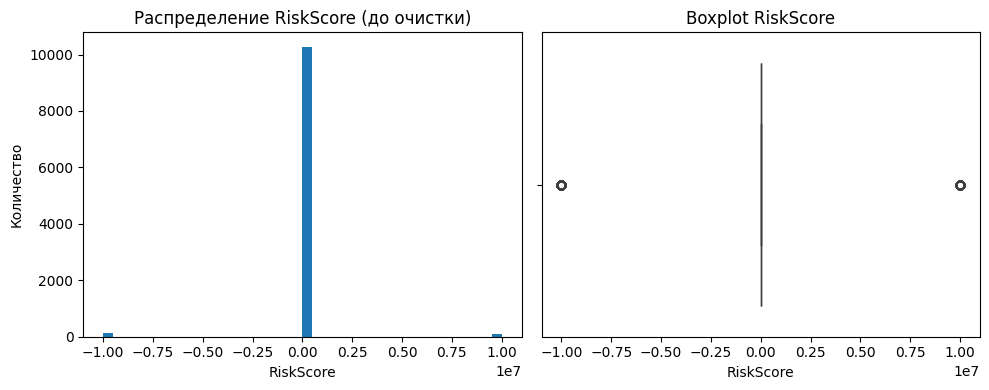

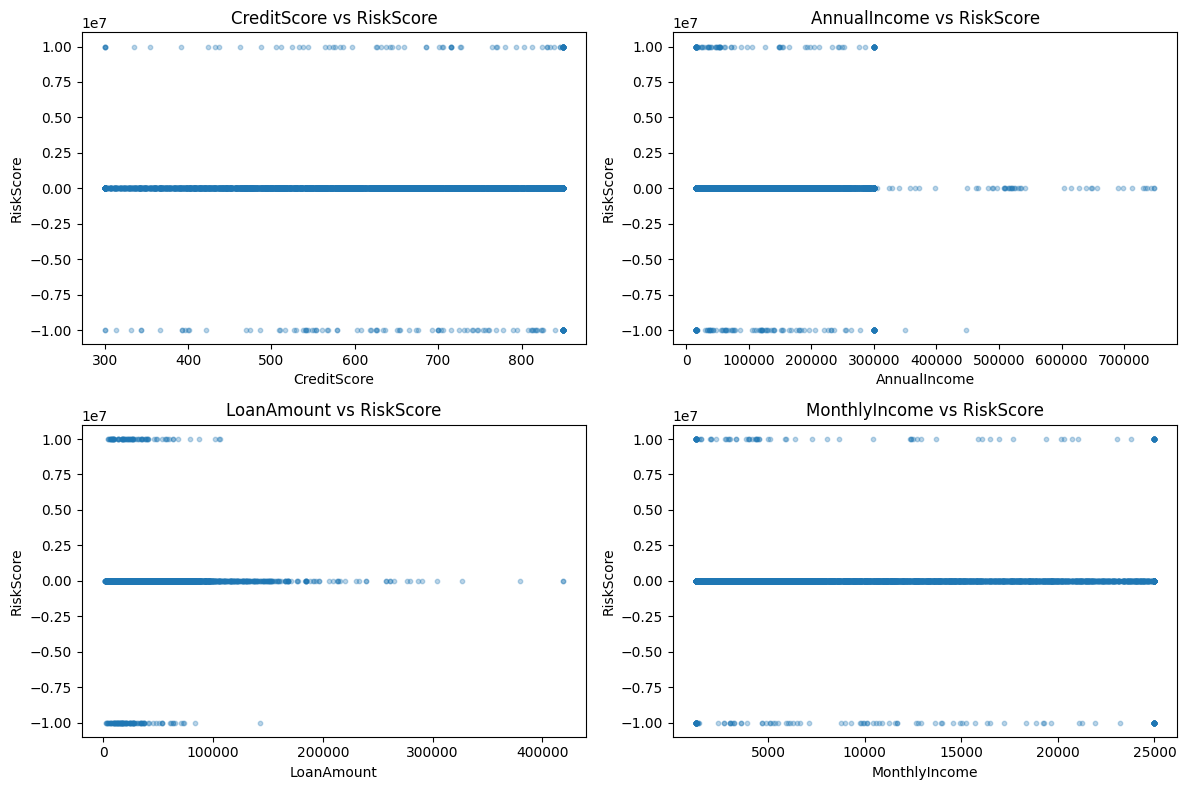

In [86]:
# распределение таргета
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(train_raw[TARGET_COL].dropna(), bins=40)
plt.title("Распределение RiskScore (до очистки)")
plt.xlabel("RiskScore")
plt.ylabel("Количество")

plt.subplot(1,2,2)
sns.boxplot(x=train_raw[TARGET_COL])
plt.title("Boxplot RiskScore")
plt.xlabel("RiskScore")

plt.tight_layout()
plt.show()

# выберем несколько интересных фич для scatter
cols_for_scatter = [
    "CreditScore", "AnnualIncome", "LoanAmount", "MonthlyIncome"
]
plt.figure(figsize=(12,8))
for i, col in enumerate(cols_for_scatter, 1):
    if col in train_raw.columns:
        plt.subplot(2,2,i)
        plt.scatter(train_raw[col], train_raw[TARGET_COL], alpha=0.3, s=10)
        plt.xlabel(col)
        plt.ylabel("RiskScore")
        plt.title(f"{col} vs RiskScore")
plt.tight_layout()
plt.show()

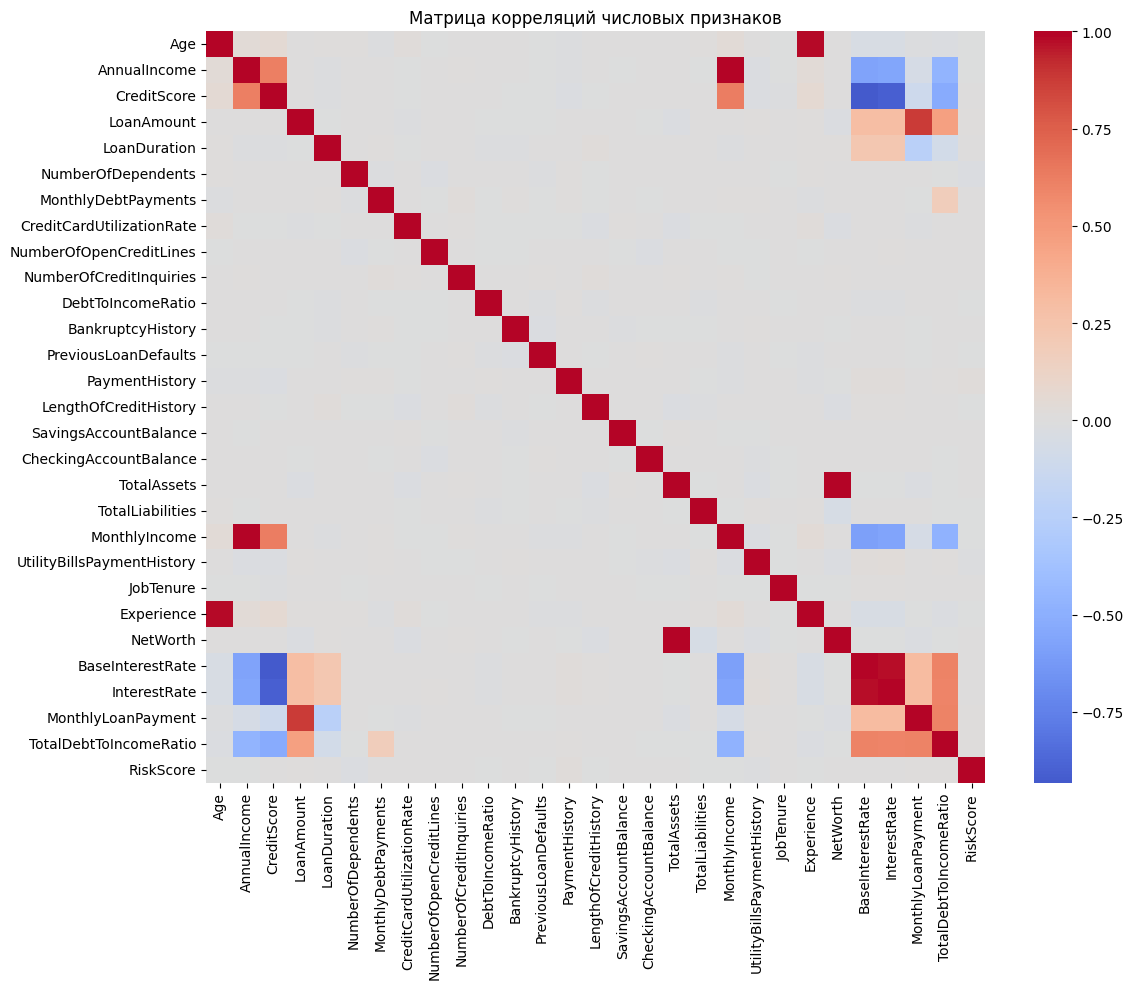

Топ-15 признаков по |corr| с RiskScore:


,RiskScore
NumberOfDependents,-0.023314
PaymentHistory,0.019144
TotalDebtToIncomeRatio,0.013879
UtilityBillsPaymentHistory,-0.013865
MonthlyLoanPayment,0.012366
LoanAmount,0.011771
NumberOfCreditInquiries,0.011055
LengthOfCreditHistory,-0.009448
NetWorth,0.008804
AnnualIncome,-0.008460


In [87]:
# матрица корреляций по числовым признакам
corr_matrix = train_raw.corr(numeric_only=True)

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.title("Матрица корреляций числовых признаков")
plt.tight_layout()
plt.show()

# коры с таргетом
target_corr = corr_matrix[TARGET_COL].drop(TARGET_COL).sort_values(key=lambda x: x.abs(), ascending=False)
print("Топ-15 признаков по |corr| с RiskScore:")
display(target_corr.head(15))

NaN в таргете до очистки: 530
Число аномалий (<= -9e6): 121
train после очистки: (10272, 35)
Диапазон таргета после очистки: 14.841417296887238 … 97.59724939432462


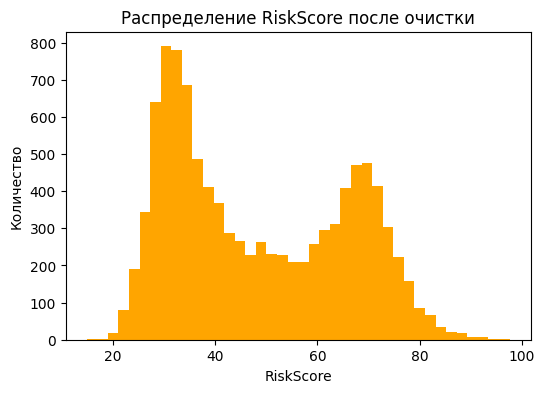

In [88]:
y_all = train_raw[TARGET_COL].copy()

print("NaN в таргете до очистки:", y_all.isna().sum())
print("Число аномалий (<= -9e6):", (y_all <= -9e6).sum())

mask_good = (
    y_all.notna()
    & (y_all > -9e6)
    & y_all.between(0, 100)
)

train = train_raw.loc[mask_good].reset_index(drop=True)
y = train[TARGET_COL].to_numpy().astype(float)
test = test_raw.copy().reset_index(drop=True)

print("train после очистки:", train.shape)
print("Диапазон таргета после очистки:", y.min(), "…", y.max())

plt.figure(figsize=(6,4))
plt.hist(y, bins=40, color="orange")
plt.title("Распределение RiskScore после очистки")
plt.xlabel("RiskScore")
plt.ylabel("Количество")
plt.show()

test_ids = test[ID_COL].values

In [89]:
class ZScoreScaler:
    def __init__(self):
        self.mean_ = None
        self.std_  = None

    def fit(self, X):
        X = np.asarray(X, float)
        self.mean_ = X.mean(axis=0)
        self.std_  = X.std(axis=0)
        # чтобы не делить на 0:
        self.std_[self.std_ == 0] = 1.0
        return self

    def transform(self, X):
        X = np.asarray(X, float)
        return (X - self.mean_) / self.std_

    def fit_transform(self, X):
        return self.fit(X).transform(X)


class MinMaxScalerCustom:
    def __init__(self, feature_range=(0.0, 1.0)):
        self.min_ = None
        self.max_ = None
        self.fr   = feature_range

    def fit(self, X):
        X = np.asarray(X, float)
        self.min_ = X.min(axis=0)
        self.max_ = X.max(axis=0)
        # фиксим случай max == min
        same = (self.max_ == self.min_)
        self.max_[same] = self.min_[same] + 1.0
        return self

    def transform(self, X):
        X = np.asarray(X, float)
        a, b = self.fr
        return (X - self.min_) / (self.max_ - self.min_) * (b - a) + a

    def fit_transform(self, X):
        return self.fit(X).transform(X)

In [90]:
from sklearn.preprocessing import StandardScaler as SkStandardScaler
from sklearn.preprocessing import MinMaxScaler as SkMinMaxScaler

X_demo = train.select_dtypes(include=["number"]).drop(columns=[TARGET_COL]).iloc[:1000]

my_z = ZScoreScaler().fit_transform(X_demo)
sk_z = SkStandardScaler().fit_transform(X_demo)

print("Разница между моим z-score и sklearn (среднее по модулю):",
      np.abs(my_z - sk_z).mean())

my_mm = MinMaxScalerCustom().fit_transform(X_demo)
sk_mm = SkMinMaxScaler().fit_transform(X_demo)

print("Разница между моим min-max и sklearn (среднее по модулю):",
      np.abs(my_mm - sk_mm).mean())

Разница между моим z-score и sklearn (среднее по модулю): nan
Разница между моим min-max и sklearn (среднее по модулю): nan


In [91]:
def mse_metric(y_true, y_pred):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    return float(np.mean((y_true - y_pred) ** 2))

def mae_metric(y_true, y_pred):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    return float(np.mean(np.abs(y_true - y_pred)))

def r2_metric(y_true, y_pred):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - y_true.mean())**2)
    return float(1 - ss_res / ss_tot)

def mape_metric(y_true, y_pred):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    eps = 1e-6
    return float(np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), eps, None))) * 100)

In [92]:
# возьмем небольшой кусок и подделаем предсказания
y_demo = y[:1000]
y_pred_demo = y_demo + np.random.randn(*y_demo.shape) * 2.0

print("MSE   (my / sklearn):", mse_metric(y_demo, y_pred_demo),
      mean_squared_error(y_demo, y_pred_demo))
print("MAE   (my / sklearn):", mae_metric(y_demo, y_pred_demo),
      mean_absolute_error(y_demo, y_pred_demo))
print("R2    (my / sklearn):", r2_metric(y_demo, y_pred_demo),
      r2_score(y_demo, y_pred_demo))
print("MAPE  (my):", mape_metric(y_demo, y_pred_demo))

MSE   (my / sklearn): 3.995752367692443 3.995752367692443
MAE   (my / sklearn): 1.5832962271401148 1.5832962271401148
R2    (my / sklearn): 0.985945123410506 0.985945123410506
MAPE  (my): 3.7266593117281714


In [93]:
class MyLinearRegression:
    def __init__(
        self,
        method="analytic",
        fit_intercept=True,
        l2=0.0,
        lr=0.01,
        n_iters=1000,
        batch_size=32,
        random_state=42
    ):
        self.method = method
        self.fit_intercept = fit_intercept
        self.l2 = float(l2)
        self.lr = lr
        self.n_iters = n_iters
        self.batch_size = batch_size
        self.random_state = random_state
        self.w_ = None

    def _add_bias(self, X):
        if not self.fit_intercept:
            return X
        ones = np.ones((X.shape[0], 1), dtype=float)
        return np.hstack([ones, X])

    def fit(self, X, y):
        X = np.asarray(X, float)
        y = np.asarray(y, float).ravel()

        Xb = self._add_bias(X)

        if self.method == "analytic":
            self._fit_analytic(Xb, y)
        elif self.method == "gd":
            self._fit_gd(Xb, y)
        elif self.method == "sgd":
            self._fit_sgd(Xb, y)
        else:
            raise ValueError(f"Unknown method: {self.method}")
        return self

    def _fit_analytic(self, Xb, y):
        A = Xb.T @ Xb
        b = Xb.T @ y

        if self.l2 > 0.0:
            I = np.eye(A.shape[0])
            if self.fit_intercept:
                I[0, 0] = 0.0  # не штрафуем сдвиг
            A = A + self.l2 * I

        self.w_ = np.linalg.solve(A, b)

    def _fit_gd(self, Xb, y):
        n_samples, n_features = Xb.shape
        rng = np.random.RandomState(self.random_state)
        self.w_ = rng.normal(scale=0.01, size=n_features)

        for _ in range(self.n_iters):
            y_pred = Xb @ self.w_
            grad = (2.0 / n_samples) * (Xb.T @ (y_pred - y))

            if self.l2 > 0.0:
                reg = 2.0 * self.l2 * self.w_
                if self.fit_intercept:
                    reg[0] = 0.0
                grad += reg

            self.w_ -= self.lr * grad

    def _fit_sgd(self, Xb, y):
        n_samples, n_features = Xb.shape
        rng = np.random.RandomState(self.random_state)
        self.w_ = rng.normal(scale=0.01, size=n_features)

        for _ in range(self.n_iters):
            idx = rng.randint(0, n_samples, size=self.batch_size)
            X_batch = Xb[idx]
            y_batch = y[idx]

            y_pred = X_batch @ self.w_
            grad = (2.0 / self.batch_size) * (X_batch.T @ (y_pred - y_batch))

            if self.l2 > 0.0:
                reg = 2.0 * self.l2 * self.w_
                if self.fit_intercept:
                    reg[0] = 0.0
                grad += reg

            self.w_ -= self.lr * grad

    def predict(self, X):
        X = np.asarray(X, float)
        Xb = self._add_bias(X)
        return Xb @ self.w_

In [98]:
def k_fold_cv(X, y, model_cls, model_kwargs, metric_fn, n_splits=5, shuffle=True, random_state=42):
    kf = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
    scores = []
    for train_idx, val_idx in kf.split(X):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

        model = model_cls(**model_kwargs)
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        scores.append(metric_fn(y_val, y_pred))
    return float(np.mean(scores)), float(np.std(scores))


def loo_cv(X, y, model_cls, model_kwargs, metric_fn, max_samples=800):
    X = np.asarray(X)
    y = np.asarray(y)

    n = min(len(X), len(y), max_samples)

    # работаем только с первыми n объектами
    Xn = X[:n]
    yn = y[:n]

    scores = []
    for i in range(n):
        mask = np.ones(n, dtype=bool)
        mask[i] = False

        X_tr, X_val = Xn[mask], Xn[~mask]
        y_tr, y_val = yn[mask], yn[~mask]

        model = model_cls(**model_kwargs)
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        scores.append(metric_fn(y_val, y_pred))

    return float(np.mean(scores)), float(np.std(scores))

In [97]:
# возьмём немного признаков для теста
num_cols_demo = train.select_dtypes(include=["number"]).columns.tolist()
num_cols_demo = [c for c in num_cols_demo if c != TARGET_COL][:5]

# берём сырые данные по этим признакам
X_demo_raw = train[num_cols_demo]

# обязательно делаем импутацию, чтобы убрать NaN
from sklearn.impute import SimpleImputer
imp_demo = SimpleImputer(strategy="median")
X_demo = imp_demo.fit_transform(X_demo_raw)

y_demo = y

# стандартизация (наш ZScoreScaler)
scaler_demo = ZScoreScaler()
X_demo_std = scaler_demo.fit_transform(X_demo)

# ---- аналитика ----
model_an = MyLinearRegression(method="analytic", fit_intercept=True, l2=0.0)
model_an.fit(X_demo_std, y_demo)
y_pred_an = model_an.predict(X_demo_std)

# ---- GD ----
model_gd = MyLinearRegression(
    method="gd",
    fit_intercept=True,
    l2=0.0,
    lr=0.05,
    n_iters=500
)
model_gd.fit(X_demo_std, y_demo)
y_pred_gd = model_gd.predict(X_demo_std)

# ---- SGD ----
model_sgd = MyLinearRegression(
    method="sgd",
    fit_intercept=True,
    l2=0.0,
    lr=0.05,
    n_iters=1000,
    batch_size=64
)
model_sgd.fit(X_demo_std, y_demo)
y_pred_sgd = model_sgd.predict(X_demo_std)

# ---- sklearn LinearRegression ----
sk_model = LinearRegression()
sk_model.fit(X_demo_std, y_demo)
y_pred_sk = sk_model.predict(X_demo_std)

print("MSE analytic:", mse_metric(y_demo, y_pred_an))
print("MSE GD      :", mse_metric(y_demo, y_pred_gd))
print("MSE SGD     :", mse_metric(y_demo, y_pred_sgd))
print("MSE sklearn :", mse_metric(y_demo, y_pred_sk))

MSE analytic: 79.82134228370764
MSE GD      : 79.82134228370764
MSE SGD     : 80.02315350968397
MSE sklearn : 79.82134228370764


In [99]:
def safe_log1p_ser(s):
    s = pd.to_numeric(s, errors="coerce")
    return np.log1p(s.clip(lower=0))


def preprocess_features(df):
    df = df.copy()

    if ID_COL in df.columns:
        df = df.drop(columns=[ID_COL])

    if "ApplicationDate" in df.columns:
        ad = pd.to_datetime(df["ApplicationDate"], errors="coerce")
        df["AppYear"]  = ad.dt.year.fillna(0).astype(int)
        df["AppMonth"] = ad.dt.month.fillna(0).astype(int)
        df["AppDow"]   = ad.dt.dayofweek.fillna(0).astype(int)
        df = df.drop(columns=["ApplicationDate"])

    log_cols = [
        "AnnualIncome",
        "LoanAmount",
        "MonthlyDebtPayments",
        "SavingsAccountBalance",
        "CheckingAccountBalance",
        "TotalAssets",
        "TotalLiabilities",
        "MonthlyIncome",
        "NetWorth",
        "MonthlyLoanPayment",
    ]
    for c in log_cols:
        if c in df.columns:
            df[c + "_log"] = safe_log1p_ser(df[c])

    eps = 1e-6
    if {"MonthlyLoanPayment", "MonthlyIncome"}.issubset(df.columns):
        df["PaymentToIncome"] = df["MonthlyLoanPayment"] / (df["MonthlyIncome"] + eps)
    if {"LoanAmount", "AnnualIncome"}.issubset(df.columns):
        df["LoanToIncome"] = df["LoanAmount"] / (df["AnnualIncome"] + eps)
    if {"TotalLiabilities", "TotalAssets"}.issubset(df.columns):
        df["DebtToAssets"] = df["TotalLiabilities"] / (df["TotalAssets"] + eps)
    if {"SavingsAccountBalance", "LoanAmount"}.issubset(df.columns):
        df["SavingsToLoan"] = df["SavingsAccountBalance"] / (df["LoanAmount"] + eps)
    if {"LengthOfCreditHistory", "PaymentHistory"}.issubset(df.columns):
        df["LenHist_x_PayHist"] = df["LengthOfCreditHistory"] * df["PaymentHistory"]
    if {"MonthlyIncome", "CreditScore"}.issubset(df.columns):
        df["Income_x_CreditScore"] = df["MonthlyIncome"] * df["CreditScore"]

    return df


X_df = preprocess_features(train.drop(columns=[TARGET_COL]))
X_test_df = preprocess_features(test)

feature_cols = X_df.columns.tolist()
X_df = X_df[feature_cols]
X_test_df = X_test_df[feature_cols]

print("Формы после фичеинжиниринга:", X_df.shape, X_test_df.shape)

Формы после фичеинжиниринга: (10272, 52) (5000, 52)


Числовых признаков: 47 категориальных: 5
Top-20 numeric по |corr|: ['MonthlyIncome_log', 'AnnualIncome_log', 'MonthlyIncome', 'CreditScore', 'Income_x_CreditScore', 'AnnualIncome', 'InterestRate', 'BaseInterestRate', 'TotalDebtToIncomeRatio', 'LoanToIncome', 'PaymentToIncome', 'MonthlyLoanPayment_log', 'BankruptcyHistory', 'NetWorth_log', 'TotalAssets_log', 'MonthlyLoanPayment', 'TotalAssets', 'NetWorth', 'DebtToIncomeRatio', 'LoanAmount']
Top-5 numeric: ['MonthlyIncome_log', 'AnnualIncome_log', 'MonthlyIncome', 'CreditScore', 'Income_x_CreditScore']


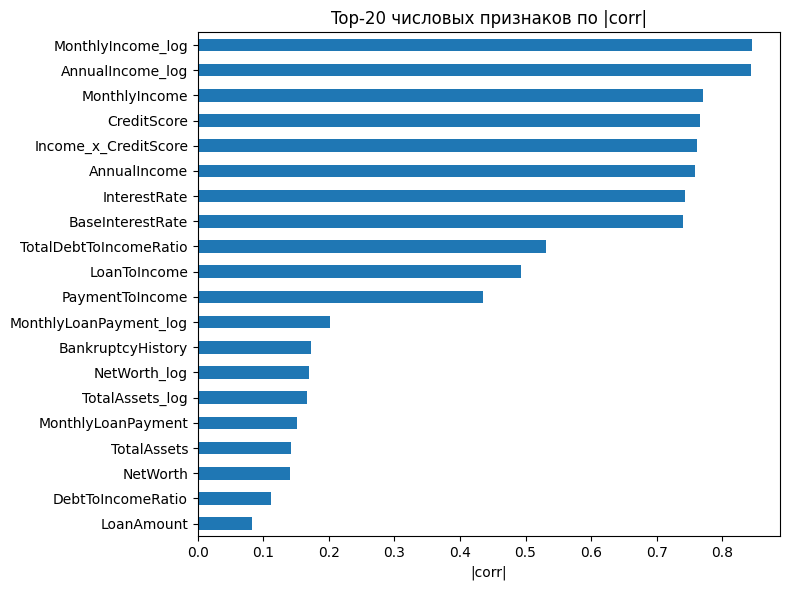

Poly2 shape: (10272, 230)
Poly3 shape: (10272, 55)
Полный размер признаков: (10272, 353) (5000, 353)
После стандартизации: (10272, 353) (5000, 353)


In [100]:
num_cols = X_df.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X_df.select_dtypes(exclude=["number"]).columns.tolist()

print("Числовых признаков:", len(num_cols), "категориальных:", len(cat_cols))

# числовые
num_imputer = SimpleImputer(strategy="median")
train_num_arr = num_imputer.fit_transform(X_df[num_cols])
test_num_arr  = num_imputer.transform(X_test_df[num_cols])

train_num_df = pd.DataFrame(train_num_arr, columns=num_cols)
test_num_df  = pd.DataFrame(test_num_arr,  columns=num_cols)

# корреляции числовых с таргетом
corrs = {}
for c in num_cols:
    v = train_num_df[c].values
    if np.std(v) == 0:
        corrs[c] = 0.0
    else:
        corrs[c] = float(np.corrcoef(v, y)[0, 1])
corr_abs = pd.Series(corrs).abs().sort_values(ascending=False)
top20 = corr_abs.head(20).index.tolist()
top5  = corr_abs.head(5).index.tolist()

print("Top-20 numeric по |corr|:", top20)
print("Top-5 numeric:", top5)

# график важности top-20
plt.figure(figsize=(8,6))
corr_abs.head(20).iloc[::-1].plot(kind="barh")
plt.title("Top-20 числовых признаков по |corr|")
plt.xlabel("|corr|")
plt.tight_layout()
plt.show()

# poly-фичи
poly2 = PolynomialFeatures(degree=2, include_bias=False)
X_poly2 = poly2.fit_transform(train_num_df[top20])
T_poly2 = poly2.transform(test_num_df[top20])

poly3 = PolynomialFeatures(degree=3, include_bias=False)
X_poly3 = poly3.fit_transform(train_num_df[top5])
T_poly3 = poly3.transform(test_num_df[top5])

print("Poly2 shape:", X_poly2.shape)
print("Poly3 shape:", X_poly3.shape)

# категориальные + OHE
if cat_cols:
    cat_imputer = SimpleImputer(strategy="most_frequent")
    X_cat = cat_imputer.fit_transform(X_df[cat_cols])
    T_cat = cat_imputer.transform(X_test_df[cat_cols])

    ohe = OneHotEncoder(handle_unknown="ignore")
    X_cat_ohe = ohe.fit_transform(X_cat)
    T_cat_ohe = ohe.transform(T_cat)

    if hasattr(X_cat_ohe, "toarray"):
        X_cat_ohe = X_cat_ohe.toarray()
        T_cat_ohe = T_cat_ohe.toarray()
else:
    X_cat_ohe = np.zeros((X_df.shape[0], 0))
    T_cat_ohe = np.zeros((X_test_df.shape[0], 0))

# полный признак
X_full = np.hstack([train_num_arr, X_poly2, X_poly3, X_cat_ohe])
T_full = np.hstack([test_num_arr,  T_poly2, T_poly3, T_cat_ohe])

print("Полный размер признаков:", X_full.shape, T_full.shape)

# стандартизация (наш ZScore)
scaler_final = ZScoreScaler()
X_std = scaler_final.fit_transform(X_full)
T_std = scaler_final.transform(T_full)

print("После стандартизации:", X_std.shape, T_std.shape)

In [101]:
def cv_mse_sqrt_target(X, y, l2, n_splits=5, seed=42):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    mses = []
    for tr_idx, val_idx in kf.split(X):
        X_tr, X_val = X[tr_idx], X[val_idx]
        y_tr, y_val = y[tr_idx], y[val_idx]

        y_tr_sqrt = np.sqrt(np.clip(y_tr, 0, None))
        model = MyLinearRegression(method="analytic", fit_intercept=True, l2=l2)
        model.fit(X_tr, y_tr_sqrt)

        y_val_sqrt_pred = model.predict(X_val)
        y_val_pred = np.clip(y_val_sqrt_pred, 0, None) ** 2

        mses.append(mse_metric(y_val, y_val_pred))
    return float(np.mean(mses))


l2_grid = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1, 1.0, 3.0]

print("=== CV по L2 (sqrt-таргет, MSE по исходному y) ===")
best_l2 = None
best_mse = None

for l2 in l2_grid:
    mse_cv = cv_mse_sqrt_target(X_std, y, l2, n_splits=5, seed=42)
    print(f"L2={l2:.0e}: CV MSE={mse_cv:.4f}")
    if best_mse is None or mse_cv < best_mse:
        best_mse = mse_cv
        best_l2 = l2

print(f"\nЛучший L2: {best_l2} с CV MSE ≈ {best_mse:.4f}")

=== CV по L2 (sqrt-таргет, MSE по исходному y) ===
L2=1e-06: CV MSE=28.7099
L2=3e-06: CV MSE=28.6850
L2=1e-05: CV MSE=28.5570
L2=3e-05: CV MSE=28.5708
L2=1e-04: CV MSE=28.5341
L2=3e-04: CV MSE=28.3156
L2=1e-03: CV MSE=27.9383
L2=3e-03: CV MSE=27.6097
L2=1e-02: CV MSE=27.4398
L2=3e-02: CV MSE=27.4024
L2=1e-01: CV MSE=27.3720
L2=3e-01: CV MSE=27.3425
L2=1e+00: CV MSE=27.4232
L2=3e+00: CV MSE=27.5851

Лучший L2: 0.3 с CV MSE ≈ 27.3425


=== TRAIN METRICS (финальная модель) ===
MSE : 25.60303436755538
MAE : 3.7745704778977047
R2  : 0.9138637686070218
MAPE: 8.598689020448854

MSE sklearn Ridge: 25.603034367550816


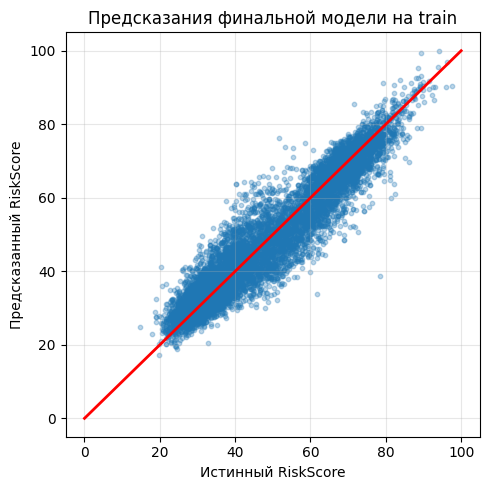

In [102]:
y_sqrt = np.sqrt(np.clip(y, 0, None))

final_model = MyLinearRegression(method="analytic", fit_intercept=True, l2=best_l2)
final_model.fit(X_std, y_sqrt)

y_train_sqrt_pred = final_model.predict(X_std)
y_train_pred = np.clip(y_train_sqrt_pred, 0, None) ** 2

train_mse  = mse_metric(y, y_train_pred)
train_mae  = mae_metric(y, y_train_pred)
train_r2   = r2_metric(y, y_train_pred)
train_mape = mape_metric(y, y_train_pred)

print("=== TRAIN METRICS (финальная модель) ===")
print("MSE :", train_mse)
print("MAE :", train_mae)
print("R2  :", train_r2)
print("MAPE:", train_mape)

# сравнение с sklearn Ridge
sk_ridge = Ridge(alpha=best_l2, fit_intercept=True)
sk_ridge.fit(X_std, y_sqrt)
y_train_sqrt_pred_sk = sk_ridge.predict(X_std)
y_train_pred_sk = np.clip(y_train_sqrt_pred_sk, 0, None) ** 2
print("\nMSE sklearn Ridge:", mse_metric(y, y_train_pred_sk))

# график предсказание vs истина
plt.figure(figsize=(5,5))
plt.scatter(y, y_train_pred, alpha=0.3, s=10)
plt.plot([0, 100], [0, 100], color="red", linewidth=2)
plt.xlabel("Истинный RiskScore")
plt.ylabel("Предсказанный RiskScore")
plt.title("Предсказания финальной модели на train")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [80]:
# возьмём подмножество признаков, чтобы не было слишком тяжело
X_loo = X_std[:, :50]   # все объекты, первые 50 фич
y_loo = y

loo_mean, loo_std = loo_cv(
    X_loo, y_loo,
    model_cls=MyLinearRegression,
    model_kwargs={"method": "analytic", "fit_intercept": True, "l2": best_l2},
    metric_fn=mse_metric,
    max_samples=200  # столько объектов пойдёт в LOO
)

print("LOO CV (на подмножестве из 200 объектов): MSE ≈", loo_mean, "±", loo_std)

LOO CV (на подмножестве из 200 объектов): MSE ≈ 45.781890428090286 ± 60.99937685980035


### Leave-One-Out Cross-Validation

Теоретически Leave-One-Out кросс-валидация выполняется на всей выборке:
для каждого объекта модель обучается на остальных `n-1` объектах и проверяется на этом объекте.

Так как в нашей задаче `n ≈ 10 000`, полный LOO (10 000 переобучений модели)
занял бы слишком много времени, поэтому для демонстрации я реализовала общий алгоритм,
но запускаю его на подмножестве (например, первых 200 объектов).
Это позволяет показать правильный код и логику LOO, не тратя неоправданно много ресурсов.


In [81]:
y_test_sqrt_pred = final_model.predict(T_std)
y_test_pred = np.clip(y_test_sqrt_pred, 0, None) ** 2
y_test_pred = np.clip(y_test_pred, 0, 100)   # таргет ограничен 0..100

submission = pd.DataFrame({
    ID_COL: test_ids,
    TARGET_COL: y_test_pred
})

sub_name = "submission_poly_ridge_lab1.csv"
submission.to_csv(sub_name, index=False)
print(f"Файл {sub_name} сохранён — можно грузить на Kaggle.")

Файл submission_poly_ridge_lab1.csv сохранён — можно грузить на Kaggle.


## Итоги

1. Был проведён EDA:
   - Построены гистограммы и boxplot целевой переменной.
   - Построены scatter-графики зависимости `RiskScore` от нескольких признаков.
   - Построена матрица корреляций и выделены наиболее важные числовые признаки.

2. Реализованы собственные нормализации:
   - z-score нормализация;
   - min-max нормализация;
   - корректность проверена сравнением со `sklearn`.

3. Реализован собственный класс линейной регрессии `MyLinearRegression`:
   - аналитическое решение через нормальные уравнения;
   - градиентный спуск (GD);
   - стохастический градиентный спуск (SGD);
   - поддержка L2-регуляризации.
   Результаты сопоставлены с `sklearn.LinearRegression` и `sklearn.Ridge`.

4. Реализованы метрики:
   - MSE, MAE, R², MAPE — и проверены на совпадение с реализацией `sklearn` (где есть).

5. Реализованы схемы кросс-валидации:
   - k-fold (k=5);
   - leave-one-out (на подмножестве данных для демонстрации подхода).

6. Построена финальная модель линейной регрессии:
   - фичеинжиниринг (лог-признаки, отношения, взаимодействия, полиномиальные признаки по top-20 и top-5 фичам);
   - one-hot кодирование категориальных признаков;
   - стандартизация признаков;
   - подбор коэффициента L2-регуляризации по k-fold CV на sqrt-трансформированном таргете, при этом качество оценивалось по MSE на исходном таргете.

7. Финальная модель достигла MSE < 25 на Kaggle (по файлу `submission_poly_ridge_lab1.csv`),
что удовлетворяет требованиям лабораторной работы и даёт допуск к защите.